#### Домашняя работа

* 1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
---
* 2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
---
* 3. При агрегации (pandas.DataFrame.groupby) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

*	общая сумма транзакций по каждой из trx_category
*	общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
*	общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
*	возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.

---

* 4. Обязательная часть: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
---
* 5. Дополнительная часть: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Метрика оценки качества - ROC AUC(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
---
* Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns
sns.set(rc={'figure.figsize':(12,6)})

In [304]:
raw_df = pd.read_csv('/Users/peter/Desktop/Проблемы качества и очистка данных 2/rosbank_train.csv')
raw_df = raw_df.drop('target_sum' , axis =1 )
# target_sum - можно выкинуть, переменная участвует в другой задаче

In [252]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


In [253]:
#для экспериментов скопируем изначальный df
experiment_df = raw_df.copy()

In [254]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 33.7+ MB


### Найдем самые популярные MCC

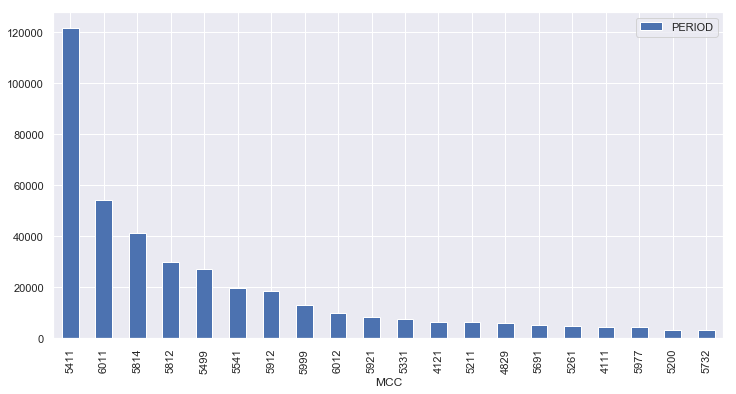

In [265]:
s = raw_df.groupby(['MCC'])['PERIOD'].count().\
    reset_index().sort_values('PERIOD', ascending = False).head(20).set_index('MCC').plot(kind='bar')

In [99]:
#5411 - Супермаркеты
#6011 - Финансовые учреждения – снятие наличности автоматически
#5814 - Фастфуд
#5812 - Общепит
#5499 - Продовольственные магазины

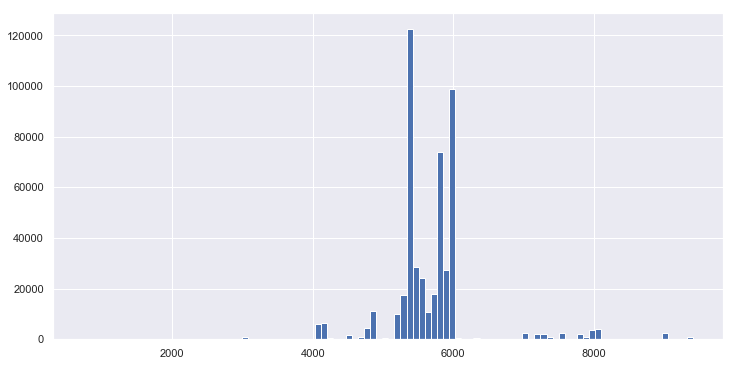

In [100]:
raw_df.MCC.hist(bins=100)

### Самый популярный вид транзакций trx_category

In [266]:
raw_df.groupby('trx_category')['PERIOD'].count().reset_index().\
    rename(columns=({'PERIOD':'count_trx'})).sort_values('count_trx', ascending = False)

,trx_category,count_trx
6,POS,416425
5,DEPOSIT,21216
9,WD_ATM_ROS,19104
8,WD_ATM_PARTNER,9948
1,C2C_IN,7306
7,WD_ATM_OTHER,7140
2,C2C_OUT,5456
0,BACK_TRX,2687
4,CAT,1197
3,CASH_ADV,34


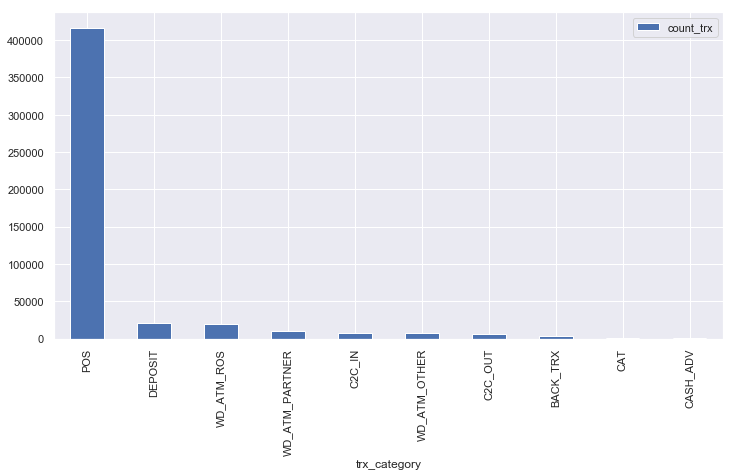

In [267]:
raw_df.groupby('trx_category')['PERIOD'].count().reset_index().\
    rename(columns=({'PERIOD':'count_trx'})).sort_values('count_trx', ascending = False).head(20).\
    set_index('trx_category').plot(kind='bar')

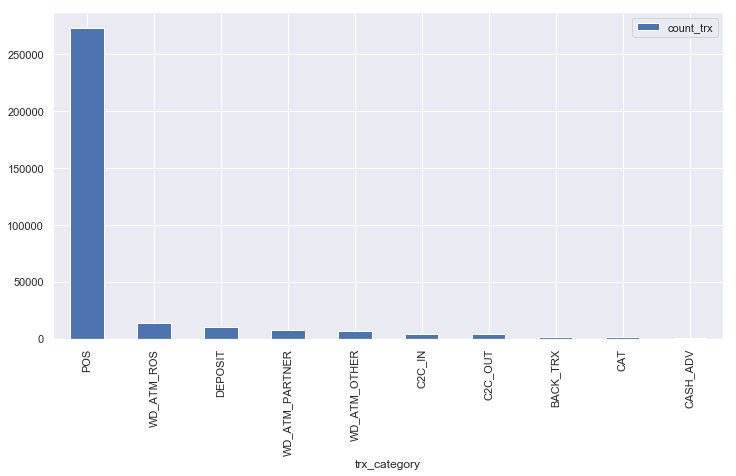

In [268]:
#Дропнувшиеся
raw_df.query('target_flag == 1').groupby('trx_category')['PERIOD'].count().reset_index().\
    rename(columns=({'PERIOD':'count_trx'})).sort_values('count_trx', ascending = False).head(20).\
    set_index('trx_category').plot(kind='bar')

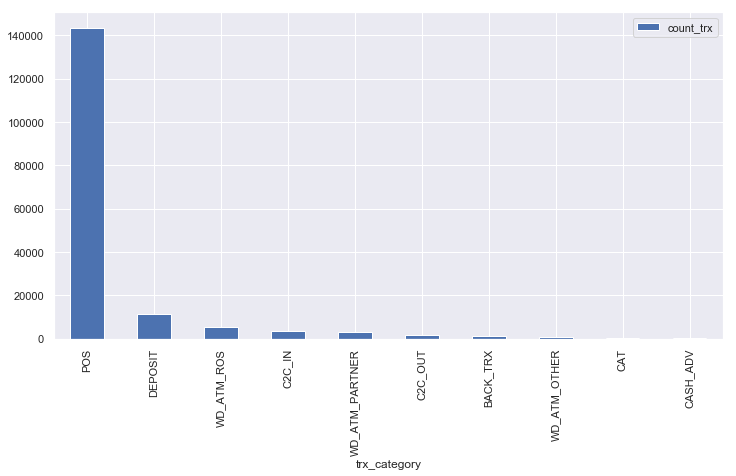

In [269]:
#Недропнувшиеся
raw_df.query('target_flag == 0').groupby('trx_category')['PERIOD'].count().reset_index().\
    rename(columns=({'PERIOD':'count_trx'})).sort_values('count_trx', ascending = False).head(20).\
    set_index('trx_category').plot(kind='bar')

In [270]:
#Дропнувшиеся в среднем на одного cl_id
(raw_df.query('target_flag == 1').groupby('trx_category')['PERIOD'].count().reset_index().\
    rename(columns=({'PERIOD':'count_trx'})).sort_values('count_trx', ascending = False).head(20).\
    set_index('trx_category')/raw_df.query('target_flag == 1')['cl_id'].nunique()).\
    reset_index().rename(columns = {'count_trx':'drop_count'})

,trx_category,drop_count
0,POS,98.661728
1,WD_ATM_ROS,4.917962
2,DEPOSIT,3.577882
3,WD_ATM_PARTNER,2.564149
4,WD_ATM_OTHER,2.301771
5,C2C_IN,1.432960
6,C2C_OUT,1.326346
7,BACK_TRX,0.572461
8,CAT,0.324178
9,CASH_ADV,0.006505


In [271]:
#Недропнувшиеся в среднем на одного cl_id
(raw_df.query('target_flag == 0').groupby('trx_category')['PERIOD'].count().reset_index().\
    rename(columns=({'PERIOD':'count_trx'})).sort_values('count_trx', ascending = False).head(20).\
    set_index('trx_category')/raw_df.query('target_flag == 0')['cl_id'].nunique()).\
    reset_index().rename(columns = {'count_trx':'no_drop_count'})

,trx_category,no_drop_count
0,POS,64.231079
1,DEPOSIT,5.067622
2,WD_ATM_ROS,2.461263
3,C2C_IN,1.496193
4,WD_ATM_PARTNER,1.277653
5,C2C_OUT,0.799821
6,BACK_TRX,0.493954
7,WD_ATM_OTHER,0.345275
8,CAT,0.134348
9,CASH_ADV,0.007165


In [272]:
df_type_of_transaction = (
    (raw_df.query('target_flag == 1').groupby('trx_category')['PERIOD'].count().reset_index().\
    rename(columns=({'PERIOD':'count_trx'})).sort_values('count_trx', ascending = False).head(20).\
    set_index('trx_category')/raw_df.query('target_flag == 1')['cl_id'].nunique()).\
    reset_index().rename(columns = {'count_trx':'drop_count'})\
    .merge(
    ((raw_df.query('target_flag == 0').groupby('trx_category')['PERIOD'].count().reset_index().\
    rename(columns=({'PERIOD':'count_trx'})).sort_values('count_trx', ascending = False).head(20).\
    set_index('trx_category')/raw_df.query('target_flag == 0')['cl_id'].nunique()).\
    reset_index().rename(columns = {'count_trx':'no_drop_count'}))))

## Для отточных клиентов:
* Падает тип транзакций: DEPOSIT
* Растет: POS, WD_ATM_PARTNER, WD_ATM_OTHER, WD_ATM_ROS, C2C_OUT
* Необходимо учитывать количество таких транзакций во разных промежутках времени от конца последней транзакции


    

In [273]:
df_type_of_transaction

,trx_category,drop_count,no_drop_count
0,POS,98.661728,64.231079
1,WD_ATM_ROS,4.917962,2.461263
2,DEPOSIT,3.577882,5.067622
3,WD_ATM_PARTNER,2.564149,1.277653
4,WD_ATM_OTHER,2.301771,0.345275
5,C2C_IN,1.432960,1.496193
6,C2C_OUT,1.326346,0.799821
7,BACK_TRX,0.572461,0.493954
8,CAT,0.324178,0.134348
9,CASH_ADV,0.006505,0.007165


_________________


### Активность по дням недели и времени

In [274]:
experiment_df['hour_of_transaction'] = experiment_df['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H'))

In [275]:
experiment_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,hour_of_transaction
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,00
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,12
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,00
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,00
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,13


### Активность по часам

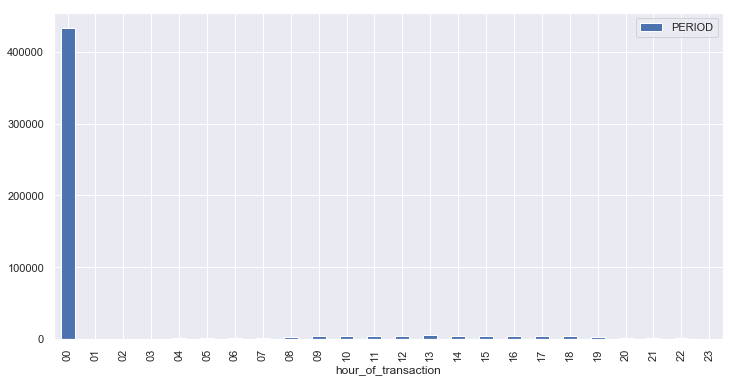

In [277]:
experiment_df.groupby('hour_of_transaction').count().iloc[:,:1].plot(kind='bar')

In [113]:
#Большое количество транзакций проходит в 00 часов, скорее всего это автоматические платежи/подписки/etc.

#Уберем их из графика.

In [278]:
a = experiment_df.groupby(['hour_of_transaction', 'MCC']).count().reset_index().iloc[:,:2]

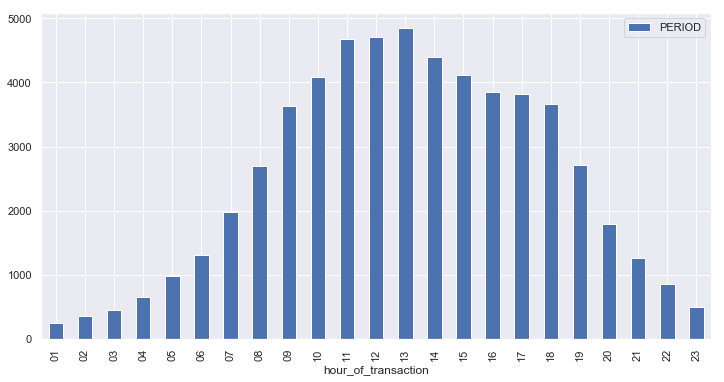

In [279]:
experiment_df.groupby('hour_of_transaction').count().iloc[1:,:1].plot(kind='bar')

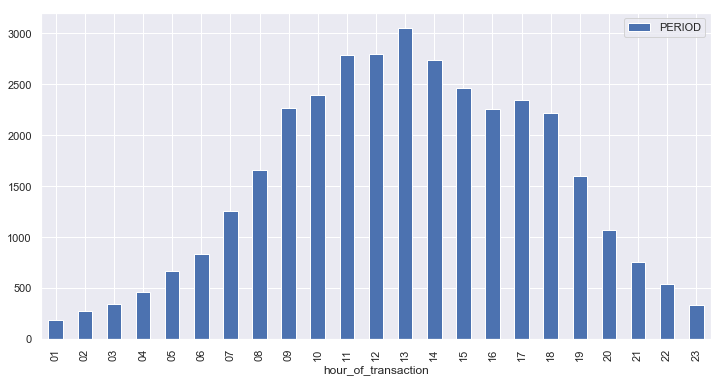

In [280]:
#Дропнувшиеся
experiment_df.query('target_flag == 1').groupby('hour_of_transaction').count().iloc[1:,:1].plot(kind='bar')

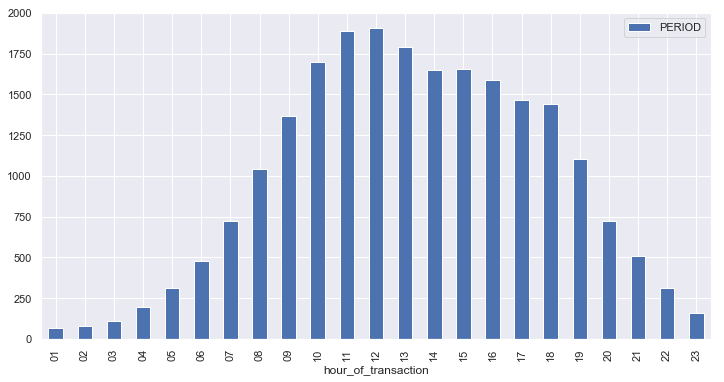

In [281]:
#Недропнувшиеся
experiment_df.query('target_flag == 0').groupby('hour_of_transaction').count().iloc[1:,:1].plot(kind='bar')

### Активность по будням и выходным

In [282]:
experiment_df['day_of_transaction'] = experiment_df['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w'))

In [283]:
experiment_df['type_day'] = experiment_df.day_of_transaction.apply(lambda x: 1 if ((int(x)==6)|(int(x)==0)) else 0)

In [284]:
experiment_df.groupby('type_day').count()['PERIOD']

type_day
0    354372
1    136141
Name: PERIOD, dtype: int64

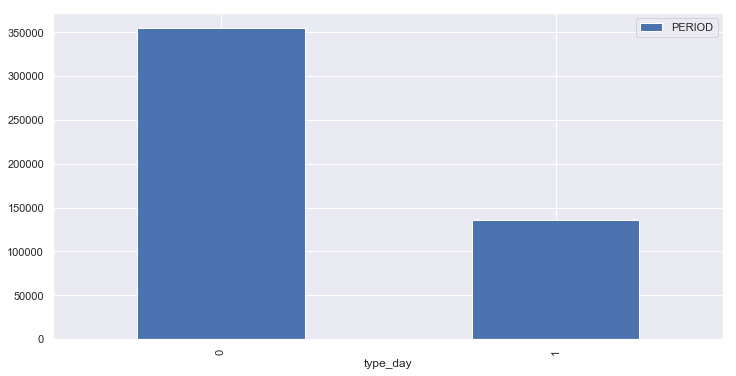

In [285]:
# 1 - выходные, 0 - будни /// добавить сюда средний чек в выходные и будни
experiment_df.groupby('type_day').count().iloc[:,:1].plot(kind='bar')

### Активность по дню недели (вс 0 - сб 7)

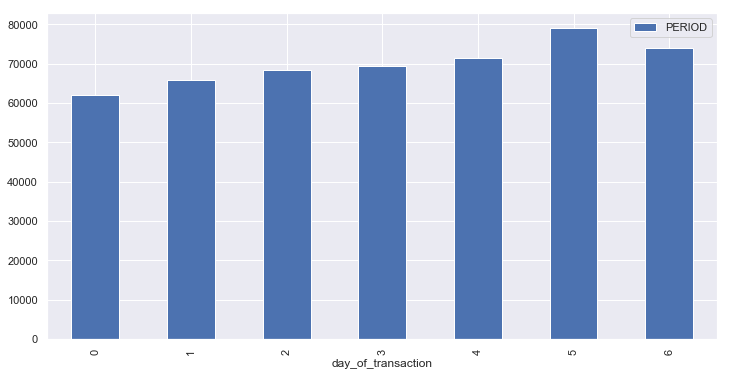

In [286]:
#наибольшее количество операций происходит в пятницу и субботу
experiment_df.groupby('day_of_transaction').count().iloc[:,:1].plot(kind='bar')

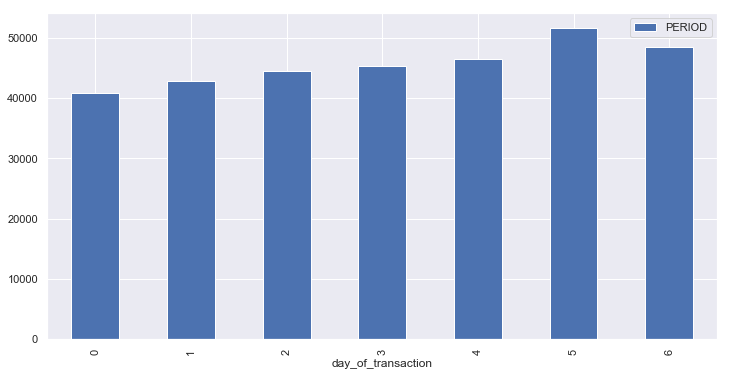

In [287]:
#Дропнувшиеся
experiment_df.query('target_flag == 1').groupby('day_of_transaction').count().iloc[:,:1].plot(kind='bar')

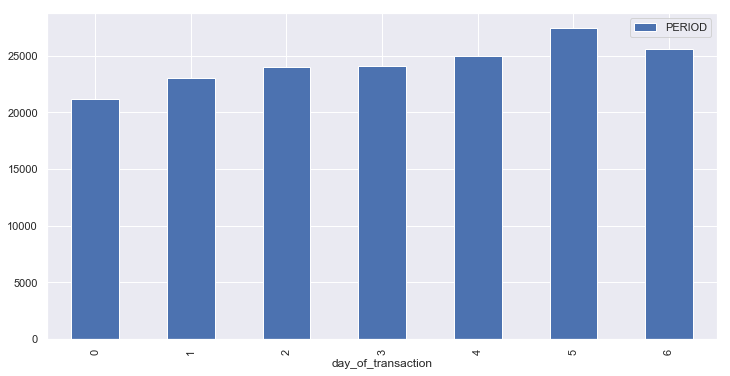

In [288]:
#Недропнувшиеся
experiment_df.query('target_flag == 0').groupby('day_of_transaction').count().iloc[:,:1].plot(kind='bar')

In [289]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


#### Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [290]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [291]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  392261
Total transactions in test dataset:  98252


In [292]:
raw_df.channel_type.unique()

array([nan, 'type5', 'type4', 'type2', 'type3', 'type1'], dtype=object)

In [293]:
raw_df.cl_id.unique()

array([    0,     1,     5, ..., 10213, 10214, 10215])

In [294]:
raw_df_grouped = raw_df[
    ['cl_id', 'amount', 'MCC']
].groupby(['cl_id', 'MCC'],as_index=False).agg(['sum', 'count']).\
reset_index()

#aggregated_dataset = raw_df_grouped.unstack().fillna(0)
#aggregated_dataset = raw_df_grouped.unstack()

In [295]:
raw_df_grouped.head()

cl_id   MCC   amount      
                   sum count
0     0  5200   5023.0     1
1     0  5411   2031.0     1
2     0  5921    767.0     1
3     0  6011  20000.0     1
4     0  6012  36562.0     1

In [296]:
raw_df_grouped.columns = ['cl_id', 'MCC','amount_sum', 'amount_count']

#### Cохраним сумму покупок по MCC и количество покупок сделанных для конкретного MCC, по каждому cl_id 
* raw_df_grouped

In [297]:
raw_df_grouped.head()

,cl_id,MCC,amount_sum,amount_count
0,0,5200,5023.0,1
1,0,5411,2031.0,1
2,0,5921,767.0,1
3,0,6011,20000.0,1
4,0,6012,36562.0,1


In [342]:
def transaction_by_day_count(dataset):
    #1_добавляем номер дня недели по каждой транзакции в виде отдельной колонки
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    #2_получаем количество транзакций за день для каждого дня недели по каждому клиент_айди
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    
    #3_похоже что проверка, вернуть название колонки из временного датасета ^ , если оно есть в переданном датасете
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    #4_ к названию всех колонок добавляем day_
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    #возвращаем 2_дф, название колонок вида day_N 
    return tmp_df

In [348]:
#для каждого клиент_айди посчитаем количество транзакций по часам
def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()

#### Создадим новые фичи:
#### 1. Количество операций в день по каждой значимой категории для каждого cliend id за различные периоды (rngdate)
#### 2. Количество операций в день по всем категориям для каждого cliend id за различные периоды


In [305]:
from dateutil.parser import parse
from datetime import datetime


raw_df['DATE_'] = raw_df['TRDATETIME'].apply(lambda x: (datetime.strptime(x, '%d%b%y:%H:%M:%S')))
raw_df['timestamp'] = raw_df['DATE_'].apply(lambda x: int(x.timestamp()))

raw_df = raw_df.merge(raw_df.groupby('cl_id').agg({'timestamp':'max'}).\
                  reset_index().rename(columns = {'timestamp':'max_timestamp'}),
                  on='cl_id', how='outer')

In [306]:
raw_df.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,DATE_,timestamp,max_timestamp
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,2017-10-21 00:00:00,1508544000,1512432000
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,2017-10-12 12:24:07,1507811047,1512432000
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,2017-12-05 00:00:00,1512432000,1512432000
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,2017-10-21 00:00:00,1508544000,1512432000
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,2017-10-24 13:14:24,1508850864,1512432000


In [308]:
rngdate = [365,180,60,30,14,7]

In [318]:
#Находим среднее кол-во операций в день по каждой категории для каждого cl_id за периоды в днях, записанные в rngdate
def count_type_operation(test):
    df = test.groupby('cl_id', as_index = False).\
        agg({'trx_category':'count'}).rename({'trx_category':'count_365'}, axis=1)
    for i in rngdate:
        temp = test[test['timestamp'] > test['max_timestamp'] - i*24*60*60].\
        groupby(['cl_id','trx_category'])['trx_category'].size().unstack().fillna(0).reset_index()
        temp = temp.filter(items=['cl_id','C2C_OUT','WD_ATM_ROS','DEPOSIT','WD_ATM_OTHER','WD_ATM_PARTNER'])
        tc = [name+str(i) for name in list(temp.columns) if name != 'cl_id']
        tc.insert(0,'cl_id')
        temp.columns = tc
        for col in list(temp.columns):
            if col != 'cl_id':
                temp[col] = temp[col].apply(lambda x: x/i)
    
        df = df.merge(temp, on='cl_id', how='left')

    df = df.drop('count_365', axis=1)
    return df

In [ ]:
#count_type_operation(raw_df)

In [325]:
#Находим среднее кол-во операций в день ВСЕГО для каждого cl_id за периоды в днях, записанные в rngdate
def count_total_operation(test):
    df_count = test.groupby('cl_id', as_index = False).\
            agg({'trx_category':'count'}).rename({'trx_category':'count_365'}, axis=1).drop('count_365',axis=1)
    for i in rngdate:
        temp_count = test[test['timestamp'] > test['max_timestamp'] - i*24*60*60].\
            groupby(['cl_id'])['PERIOD'].count().fillna(0).reset_index().rename(columns={'PERIOD':str(i)})
        
        temp_count[str(i)] = temp_count[str(i)].apply(lambda x: x/i)
        df_count = df_count.merge(temp_count, on='cl_id', how='left')
    return df_count

In [327]:
#count_total_operation(raw_df)

In [300]:
#### тут надо добавить в финальный датафрейм df_count и df

#### Создадим новую фичу - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
* def val_amount

In [141]:
def val_amount(dataset):
    return dataset.query("currency == 810 | currency == 978 | currency == 840").groupby(['cl_id','currency'])\
    ['amount'].sum().unstack().fillna(0).\
    reset_index().rename(columns={810:'rub_amount',840:'dol_amount',978:'euro_amount'})

In [328]:
#val_amount(raw_df)

### Cоберем все фичи к final_df

In [334]:
final_df = count_type_operation(raw_df).merge(count_total_operation(raw_df), how='inner', on='cl_id')

In [335]:
final_df.head()

,cl_id,C2C_OUT365,WD_ATM_ROS365,DEPOSIT365,WD_ATM_OTHER365,WD_ATM_PARTNER365,C2C_OUT180,WD_ATM_ROS180,DEPOSIT180,WD_ATM_OTHER180,...,WD_ATM_ROS7,DEPOSIT7,WD_ATM_OTHER7,WD_ATM_PARTNER7,365,180,60,30,14,7
0,0,0.002740,0.000000,0.002740,0.000000,0.000000,0.005556,0.000000,0.005556,0.000000,...,0.0,0.0,0.0,0.000000,0.013699,0.027778,0.083333,0.033333,0.071429,0.142857
1,1,0.000000,0.002740,0.005479,0.000000,0.000000,0.000000,0.005556,0.011111,0.000000,...,0.0,0.0,0.0,0.000000,0.284932,0.577778,1.516667,2.000000,1.000000,1.000000
2,5,0.021918,0.038356,0.010959,0.005479,0.005479,0.044444,0.077778,0.022222,0.011111,...,0.0,0.0,0.0,0.000000,0.389041,0.788889,1.666667,1.433333,2.142857,2.571429
3,9,0.000000,0.013699,0.002740,0.000000,0.002740,0.000000,0.027778,0.005556,0.000000,...,0.0,0.0,0.0,0.142857,0.106849,0.216667,0.333333,0.533333,0.500000,0.428571
4,10,0.052055,0.106849,0.065753,0.000000,0.008219,0.105556,0.216667,0.133333,0.000000,...,0.0,0.0,0.0,0.000000,1.268493,2.572222,5.600000,4.400000,3.785714,3.142857


In [336]:
final_df.shape

(5000, 37)

In [340]:
#####

In [337]:
final_df = final_df.merge(val_amount(raw_df), how = 'outer', on = 'cl_id')

In [338]:
final_df.head()

,cl_id,C2C_OUT365,WD_ATM_ROS365,DEPOSIT365,WD_ATM_OTHER365,WD_ATM_PARTNER365,C2C_OUT180,WD_ATM_ROS180,DEPOSIT180,WD_ATM_OTHER180,...,WD_ATM_PARTNER7,365,180,60,30,14,7,rub_amount,dol_amount,euro_amount
0,0,0.002740,0.000000,0.002740,0.000000,0.000000,0.005556,0.000000,0.005556,0.000000,...,0.000000,0.013699,0.027778,0.083333,0.033333,0.071429,0.142857,64383.00,0.0,0.00
1,1,0.000000,0.002740,0.005479,0.000000,0.000000,0.000000,0.005556,0.011111,0.000000,...,0.000000,0.284932,0.577778,1.516667,2.000000,1.000000,1.000000,266693.13,0.0,884.91
2,5,0.021918,0.038356,0.010959,0.005479,0.005479,0.044444,0.077778,0.022222,0.011111,...,0.000000,0.389041,0.788889,1.666667,1.433333,2.142857,2.571429,544874.63,0.0,51.83
3,9,0.000000,0.013699,0.002740,0.000000,0.002740,0.000000,0.027778,0.005556,0.000000,...,0.142857,0.106849,0.216667,0.333333,0.533333,0.500000,0.428571,849315.09,0.0,0.00
4,10,0.052055,0.106849,0.065753,0.000000,0.008219,0.105556,0.216667,0.133333,0.000000,...,0.000000,1.268493,2.572222,5.600000,4.400000,3.785714,3.142857,1124343.99,0.0,0.00


In [149]:
#####

In [343]:
final_df = final_df.merge(transaction_by_day_count(raw_df), how = 'inner', on = 'cl_id')

In [344]:
final_df.head()

,cl_id,C2C_OUT365,WD_ATM_ROS365,DEPOSIT365,WD_ATM_OTHER365,WD_ATM_PARTNER365,C2C_OUT180,WD_ATM_ROS180,DEPOSIT180,WD_ATM_OTHER180,...,rub_amount,dol_amount,euro_amount,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0.002740,0.000000,0.002740,0.000000,0.000000,0.005556,0.000000,0.005556,0.000000,...,64383.00,0.0,0.00,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,1,0.000000,0.002740,0.005479,0.000000,0.000000,0.000000,0.005556,0.011111,0.000000,...,266693.13,0.0,884.91,7.0,20.0,20.0,16.0,16.0,10.0,15.0
2,5,0.021918,0.038356,0.010959,0.005479,0.005479,0.044444,0.077778,0.022222,0.011111,...,544874.63,0.0,51.83,15.0,19.0,19.0,15.0,25.0,24.0,25.0
3,9,0.000000,0.013699,0.002740,0.000000,0.002740,0.000000,0.027778,0.005556,0.000000,...,849315.09,0.0,0.00,5.0,8.0,7.0,5.0,6.0,4.0,4.0
4,10,0.052055,0.106849,0.065753,0.000000,0.008219,0.105556,0.216667,0.133333,0.000000,...,1124343.99,0.0,0.00,74.0,35.0,62.0,68.0,65.0,57.0,102.0


In [346]:
final_df.shape

(5000, 47)

In [157]:
#####

In [349]:
final_df = final_df.merge(transaction_by_hour_count(raw_df), how = 'outer', on = 'cl_id')

In [353]:
final_df.head()

,cl_id,C2C_OUT365,WD_ATM_ROS365,DEPOSIT365,WD_ATM_OTHER365,WD_ATM_PARTNER365,C2C_OUT180,WD_ATM_ROS180,DEPOSIT180,WD_ATM_OTHER180,...,14_y,15,16,17,18,19,20,21,22,23
0,0,0.002740,0.000000,0.002740,0.000000,0.000000,0.005556,0.000000,0.005556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.000000,0.002740,0.005479,0.000000,0.000000,0.000000,0.005556,0.011111,0.000000,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
2,5,0.021918,0.038356,0.010959,0.005479,0.005479,0.044444,0.077778,0.022222,0.011111,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
3,9,0.000000,0.013699,0.002740,0.000000,0.002740,0.000000,0.027778,0.005556,0.000000,...,0.0,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0
4,10,0.052055,0.106849,0.065753,0.000000,0.008219,0.105556,0.216667,0.133333,0.000000,...,6.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0


In [352]:
final_df.shape

(5000, 71)

In [355]:
final_df = final_df.drop('14_y',axis=1)

In [356]:
final_df.columns

Index(['cl_id', 'C2C_OUT365', 'WD_ATM_ROS365', 'DEPOSIT365', 'WD_ATM_OTHER365',
       'WD_ATM_PARTNER365', 'C2C_OUT180', 'WD_ATM_ROS180', 'DEPOSIT180',
       'WD_ATM_OTHER180', 'WD_ATM_PARTNER180', 'C2C_OUT60', 'WD_ATM_ROS60',
       'DEPOSIT60', 'WD_ATM_OTHER60', 'WD_ATM_PARTNER60', 'C2C_OUT30',
       'WD_ATM_ROS30', 'DEPOSIT30', 'WD_ATM_OTHER30', 'WD_ATM_PARTNER30',
       'C2C_OUT14', 'WD_ATM_ROS14', 'DEPOSIT14', 'WD_ATM_OTHER14',
       'WD_ATM_PARTNER14', 'C2C_OUT7', 'WD_ATM_ROS7', 'DEPOSIT7',
       'WD_ATM_OTHER7', 'WD_ATM_PARTNER7', '365', '180', '60', '30', '14_x',
       '7', 'rub_amount', 'dol_amount', 'euro_amount', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', '00', '01', '02', '03',
       '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15', '16',
       '17', '18', '19', '20', '21', '22', '23'],
      dtype='object')

In [161]:
#####

In [162]:
#тут эксперименты

In [357]:
final_df.corr()

,cl_id,C2C_OUT365,WD_ATM_ROS365,DEPOSIT365,WD_ATM_OTHER365,WD_ATM_PARTNER365,C2C_OUT180,WD_ATM_ROS180,DEPOSIT180,WD_ATM_OTHER180,...,13,15,16,17,18,19,20,21,22,23
cl_id,1.000000,-0.084780,-0.171718,0.236587,-0.261287,-0.135424,-0.084870,-0.178514,0.235951,-0.261104,...,-0.024513,0.029076,0.002575,-0.012277,-0.004681,0.004296,-0.017709,0.013805,-0.005117,-0.002403
C2C_OUT365,-0.084780,1.000000,0.097947,0.006736,0.102530,0.095497,0.999264,0.101996,0.006919,0.102189,...,0.218525,0.208528,0.220152,0.218114,0.180026,0.190608,0.205420,0.188866,0.126218,0.178495
WD_ATM_ROS365,-0.171718,0.097947,1.000000,-0.052441,0.121768,0.117508,0.095872,0.992152,-0.052288,0.121467,...,0.352203,0.272382,0.272790,0.322985,0.256000,0.218096,0.144164,0.130259,0.078735,0.049115
DEPOSIT365,0.236587,0.006736,-0.052441,1.000000,-0.123683,-0.115519,0.007098,-0.051417,0.999535,-0.123628,...,0.321348,0.316302,0.272817,0.244100,0.301016,0.269924,0.174707,0.152910,0.140992,0.079933
WD_ATM_OTHER365,-0.261287,0.102530,0.121768,-0.123683,1.000000,0.193789,0.103419,0.126978,-0.123510,0.998787,...,0.039333,0.022992,0.013913,0.047431,0.041982,0.022595,0.036663,0.028876,0.028423,0.047935
WD_ATM_PARTNER365,-0.135424,0.095497,0.117508,-0.115519,0.193789,1.000000,0.096372,0.121617,-0.115380,0.191503,...,0.025614,0.039589,0.029620,0.053228,0.051398,0.030158,0.064599,0.068869,0.046205,0.048904
C2C_OUT180,-0.084870,0.999264,0.095872,0.007098,0.103419,0.096372,1.000000,0.100295,0.007397,0.103076,...,0.218722,0.208406,0.221561,0.219649,0.181459,0.192042,0.206728,0.190253,0.127193,0.179759
WD_ATM_ROS180,-0.178514,0.101996,0.992152,-0.051417,0.126978,0.121617,0.100295,1.000000,-0.051095,0.126957,...,0.353704,0.281236,0.280827,0.328531,0.267832,0.228449,0.149927,0.136379,0.081330,0.052132
DEPOSIT180,0.235951,0.006919,-0.052288,0.999535,-0.123510,-0.115380,0.007397,-0.051095,1.000000,-0.123456,...,0.321758,0.316052,0.272321,0.243717,0.301314,0.269581,0.173723,0.153402,0.141152,0.080292
WD_ATM_OTHER180,-0.261104,0.102189,0.121467,-0.123628,0.998787,0.191503,0.103076,0.126957,-0.123456,1.000000,...,0.039667,0.023333,0.014465,0.047036,0.041705,0.023041,0.037215,0.028915,0.028840,0.048395


In [207]:
#df_final = df_final.drop('cl_id', axis = 1)

In [362]:
final_df = final_df.merge(raw_df.groupby('cl_id').target_flag.unique().\
                              apply(lambda x: x[0]).to_frame().reset_index(), on='cl_id', how='inner')

In [406]:
final_df.head()

,cl_id,C2C_OUT365,WD_ATM_ROS365,DEPOSIT365,WD_ATM_OTHER365,WD_ATM_PARTNER365,C2C_OUT180,WD_ATM_ROS180,DEPOSIT180,WD_ATM_OTHER180,...,15,16,17,18,19,20,21,22,23,target_flag
0,0,0.002740,0.000000,0.002740,0.000000,0.000000,0.005556,0.000000,0.005556,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,0.000000,0.002740,0.005479,0.000000,0.000000,0.000000,0.005556,0.011111,0.000000,...,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0
2,5,0.021918,0.038356,0.010959,0.005479,0.005479,0.044444,0.077778,0.022222,0.011111,...,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0,1
3,9,0.000000,0.013699,0.002740,0.000000,0.002740,0.000000,0.027778,0.005556,0.000000,...,3.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,3.0,0
4,10,0.052055,0.106849,0.065753,0.000000,0.008219,0.105556,0.216667,0.133333,0.000000,...,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [391]:
final_df = final_df.fillna(0)

In [408]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 71 columns):
cl_id                5000 non-null int64
C2C_OUT365           5000 non-null float64
WD_ATM_ROS365        5000 non-null float64
DEPOSIT365           5000 non-null float64
WD_ATM_OTHER365      5000 non-null float64
WD_ATM_PARTNER365    5000 non-null float64
C2C_OUT180           5000 non-null float64
WD_ATM_ROS180        5000 non-null float64
DEPOSIT180           5000 non-null float64
WD_ATM_OTHER180      5000 non-null float64
WD_ATM_PARTNER180    5000 non-null float64
C2C_OUT60            5000 non-null float64
WD_ATM_ROS60         5000 non-null float64
DEPOSIT60            5000 non-null float64
WD_ATM_OTHER60       5000 non-null float64
WD_ATM_PARTNER60     5000 non-null float64
C2C_OUT30            5000 non-null float64
WD_ATM_ROS30         5000 non-null float64
DEPOSIT30            5000 non-null float64
WD_ATM_OTHER30       5000 non-null float64
WD_ATM_PARTNER30     5000 non-null 

___________
___________

### Разделим на трейн и тест.  Обучим модель.

In [369]:
final_df.columns

Index(['cl_id', 'C2C_OUT365', 'WD_ATM_ROS365', 'DEPOSIT365', 'WD_ATM_OTHER365',
       'WD_ATM_PARTNER365', 'C2C_OUT180', 'WD_ATM_ROS180', 'DEPOSIT180',
       'WD_ATM_OTHER180', 'WD_ATM_PARTNER180', 'C2C_OUT60', 'WD_ATM_ROS60',
       'DEPOSIT60', 'WD_ATM_OTHER60', 'WD_ATM_PARTNER60', 'C2C_OUT30',
       'WD_ATM_ROS30', 'DEPOSIT30', 'WD_ATM_OTHER30', 'WD_ATM_PARTNER30',
       'C2C_OUT14', 'WD_ATM_ROS14', 'DEPOSIT14', 'WD_ATM_OTHER14',
       'WD_ATM_PARTNER14', 'C2C_OUT7', 'WD_ATM_ROS7', 'DEPOSIT7',
       'WD_ATM_OTHER7', 'WD_ATM_PARTNER7', '365', '180', '60', '30', '14_x',
       '7', 'rub_amount', 'dol_amount', 'euro_amount', 'day_0', 'day_1',
       'day_2', 'day_3', 'day_4', 'day_5', 'day_6', '00', '01', '02', '03',
       '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '15', '16',
       '17', '18', '19', '20', '21', '22', '23', 'target_flag'],
      dtype='object')

In [401]:
y = final_df.target_flag

In [402]:
X = final_df.drop(['target_flag','cl_id'], axis = 1)

In [460]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve

In [466]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [467]:
clf = RandomForestClassifier(n_estimators=300, max_depth=30, random_state=0)\
.fit(X_train, y_train)

In [468]:
y_train_predict = clf.predict_proba(X_train)[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  1.0


In [469]:
y_test_predict = clf.predict_proba(X_test)[:, 1]


roc_auc_test = np.round(roc_auc_score(y_test, y_test_predict), 2)
print("Test: ", roc_auc_test)

Test:  0.8


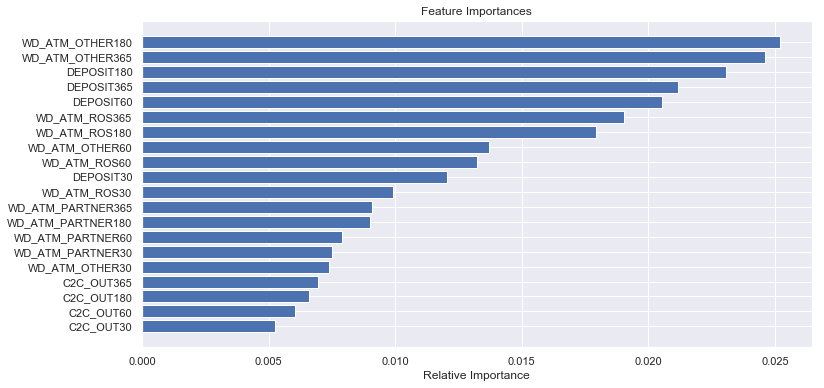

In [470]:
features = X_train.columns
importances = clf.feature_importances_[0:20]

indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()